In [1]:
# Import modules
import datetime
import spiceypy
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# Load the SPICE kernels via a meta file
spiceypy.furnsh('kernel_meta.txt')

# Create an initial date-time object that is converted to a string
DATETIME_UTC = datetime.datetime.now().strftime('%Y-%m-%dT%H:%M:%S')

# Convert to Ephemeris Time (ET) using the SPICE function utc2et
DATETIME_ET = spiceypy.utc2et(DATETIME_UTC)

# Ecliptic Coordinate System

In [2]:
# We want to compute the coordinates for different Solar System bodies as seen
# from our planet. First, a pandas dataframe is set that is used to append the
# computed data
solsys_df = pd.DataFrame()

# Add the ET and the corresponding UTC date-time string
solsys_df.loc[:, 'ET'] = [DATETIME_ET]
solsys_df.loc[:, 'UTC'] = [DATETIME_UTC]

# Set a dictionary that lists some body names and the corresponding NAIF ID
# code. Mars has the ID 499, however the loaded kernels do not contain the
# positional information. We use the Mars barycentre instead
SOLSYS_DICT = {'SUN': 10, 'VENUS': 299, 'MOON': 301, 'MARS': 4}

In [3]:
# Iterate through the dictionary and compute miscellaneous positional
# parameters
for body_name in SOLSYS_DICT:

    # First, compute the directional vector Earth - body in ECLIPJ2000. Use
    # LT+S light time correction. spkezp returns the directional vector and
    # light time. Apply [0] to get only the vector
    solsys_df.loc[:, f'dir_{body_name}_wrt_earth_ecl'] = solsys_df['ET'] \
        .apply(lambda x: spiceypy.spkezp(targ=SOLSYS_DICT[body_name], \
                                         et=x, \
                                         ref='ECLIPJ2000', \
                                         abcorr='LT+S', \
                                         obs=399)[0])

    # Compute the longitude and latitude of the body in radians in ECLIPJ2000
    # using the function recrad. recrad returns the distance, longitude and
    # latitude value; thus, apply [1] and [2] to get the longitude and
    # latitude, respectively
    solsys_df.loc[:, f'{body_name}_long_rad_ecl'] = \
        solsys_df[f'dir_{body_name}_wrt_earth_ecl'] \
            .apply(lambda x: spiceypy.recrad(x)[1])

    solsys_df.loc[:, f'{body_name}_lat_rad_ecl'] = \
        solsys_df[f'dir_{body_name}_wrt_earth_ecl'] \
            .apply(lambda x: spiceypy.recrad(x)[2])

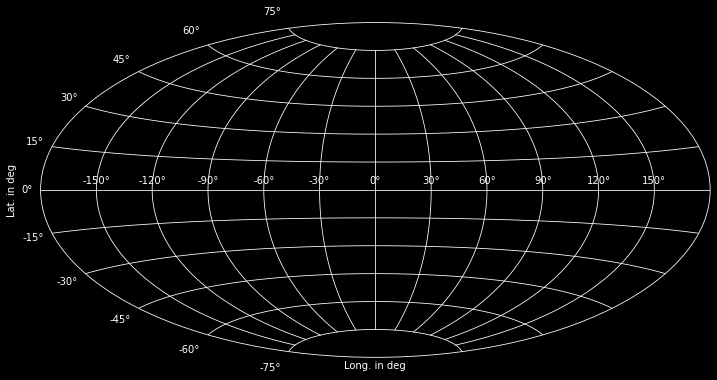

In [4]:
# Create an empty matplotlib example plot to show how matplotlib displays
# projected data

# Use a dark background
plt.style.use('dark_background')

# Set a figure
plt.figure(figsize=(12, 8))

# Apply the aitoff projection and activate the grid
plt.subplot(projection="aitoff")
plt.grid(True)

# Set long. / lat. labels
plt.xlabel('Long. in deg')
plt.ylabel('Lat. in deg')

# Save the figure
plt.savefig('empty_aitoff.png', dpi=300)

In [5]:
# Before we plot the data, we need to convert the longitude data into a
# matplotlib compatible format. We computed longitude values between 0 and
# 2*pi (360 degrees). matplotlib expects values between -pi and +pi. Further,
# sky maps count from 0 degrees longitude to the left. Thus we need also to
# invert the longitude values
for body_name in SOLSYS_DICT:

    solsys_df.loc[:, f'{body_name}_long_rad4plot_ecl'] = \
        solsys_df[f'{body_name}_long_rad_ecl'] \
            .apply(lambda x: -1*((x % np.pi) - np.pi) if x > np.pi \
                   else -1*x)

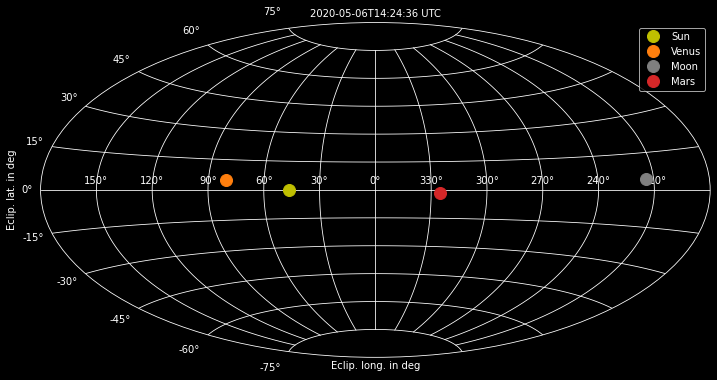

In [6]:
# Create now a sky map of the results

# Set a dark background (the night sky is ... dark)
plt.style.use('dark_background')

# Create a figure and then apply the aitoff projection
plt.figure(figsize=(12, 8))
plt.subplot(projection="aitoff")

# Set the UTC time string as a title
plt.title(f'{DATETIME_UTC} UTC', fontsize=10)

# Each body shall have an individual color; set a list with some colors
BODY_COLOR_ARRAY = ['y', 'tab:orange', 'tab:gray', 'tab:red']

# Iterate through the pandas dataframe. And plot each celestial body
for body_name, body_color in zip(SOLSYS_DICT, BODY_COLOR_ARRAY):

    # Plot the longitude and latitude data. Apply the color, and other
    # formatting parameters
    plt.plot(solsys_df[f'{body_name}_long_rad4plot_ecl'], \
             solsys_df[f'{body_name}_lat_rad_ecl'], \
             color=body_color, marker='o', linestyle='None', markersize=12, \
             label=body_name.capitalize())

# Replace the standard x ticks (longitude) with the ecliptic coordinates
plt.xticks(ticks=np.radians([-150, -120, -90, -60, -30, 0, \
                             30, 60, 90, 120, 150]),
           labels=['150°', '120°', '90°', '60°', '30°', '0°', \
                   '330°', '300°', '270°', '240°', '210°'])

# Set the axes labels
plt.xlabel('Eclip. long. in deg')
plt.ylabel('Eclip. lat. in deg')

# Create a legend and grid
plt.legend()
plt.grid(True)

# Save the figure
plt.savefig('eclipj2000_sky_map.png', dpi=300)

# Equatorial Coordinate System

In [7]:
# Now we want the coordinates in equatorial J2000. For this purpose we
# iterate through all celestial bodies
for body_name in SOLSYS_DICT:

    # First, compute the directional vector of the body as seen from Earth in
    # J2000
    solsys_df.loc[:, f'dir_{body_name}_wrt_earth_equ'] = solsys_df['ET'] \
        .apply(lambda x: spiceypy.spkezp(targ=SOLSYS_DICT[body_name], \
                                         et=x, \
                                         ref='J2000', \
                                         abcorr='LT+S', \
                                         obs=399)[0])

    # Compute the longitude and latitude values in equatorial J2000
    # coordinates
    solsys_df.loc[:, f'{body_name}_long_rad_equ'] = \
        solsys_df[f'dir_{body_name}_wrt_earth_equ'] \
            .apply(lambda x: spiceypy.recrad(x)[1])
    solsys_df.loc[:, f'{body_name}_lat_rad_equ'] = \
        solsys_df[f'dir_{body_name}_wrt_earth_equ'] \
            .apply(lambda x: spiceypy.recrad(x)[2])

    # Apply the same logic as shown before to compute the longitudes for the
    # matplotlib figure
    solsys_df.loc[:, f'{body_name}_long_rad4plot_equ'] = \
        solsys_df[f'{body_name}_long_rad_equ'] \
            .apply(lambda x: -1*((x % np.pi) - np.pi) if x > np.pi \
                   else -1*x)

In [8]:
# Before we plot the data, let's add the Ecliptic plane for the visualisation.
# In ECLIPJ2000 the Ecliptic plane is the equator line (see corresponding
# figure. The latitude is 0 degrees.

# First, we create a separate dataframe for the ecliptic plane
eclip_plane_df = pd.DataFrame()

# Add the ecliptic longitude and latitude values for the plane. Note: here,
# we need to use pi/2 (90 degrees) as the latitude, since we will apply a
# SPICE function that expects spherical coordinates
eclip_plane_df.loc[:, 'ECLIPJ2000_long_rad'] = np.linspace(0, 2*np.pi, 100)
eclip_plane_df.loc[:, 'ECLIPJ2000_lat_rad'] = np.pi/2.0

# Compute the directional vectors of the ecliptic plane for the different
# longitude values (the latitude is constant). Apply the SPICE function sphrec
# to transform the spherical coordinates to vectors. r=1 is the distance,
# here in our case: normalised distance
eclip_plane_df.loc[:, 'ECLIPJ2000_direction'] = \
    eclip_plane_df\
        .apply(lambda x: spiceypy.sphrec(r=1, \
                                         colat=x['ECLIPJ2000_lat_rad'], \
                                         lon=x['ECLIPJ2000_long_rad']), \
               axis=1)

In [9]:
# Compute a transformation matrix between ECLIPJ2000 and J2000 for a fixed
# date-time. Since both coordinate system are inertial (not changing in time)
# the resulting matrix is the same for different ETs
ECL2EQU_MAT = spiceypy.pxform(fromstr='ECLIPJ2000', \
                              tostr='J2000', \
                              et=DATETIME_ET)

# Compute the direction vectors of the Ecliptic plane in J2000 using the
# transformation matrix
eclip_plane_df.loc[:, 'j2000_direction'] = \
    eclip_plane_df['ECLIPJ2000_direction'].apply(lambda x: ECL2EQU_MAT.dot(x))

# Compute now the longitude (and matplotlib compatible version) and the
# latitude values using the SPICE function recrad
eclip_plane_df.loc[:, 'j2000_long_rad'] = \
    eclip_plane_df['j2000_direction'].apply(lambda x: spiceypy.recrad(x)[1])

eclip_plane_df.loc[:, 'j2000_long_rad4plot'] = \
    eclip_plane_df['j2000_long_rad'] \
        .apply(lambda x: -1*((x % np.pi) - np.pi) if x > np.pi \
               else -1*x)

eclip_plane_df.loc[:, 'j2000_lat_rad'] = \
    eclip_plane_df['j2000_direction'].apply(lambda x: spiceypy.recrad(x)[2])

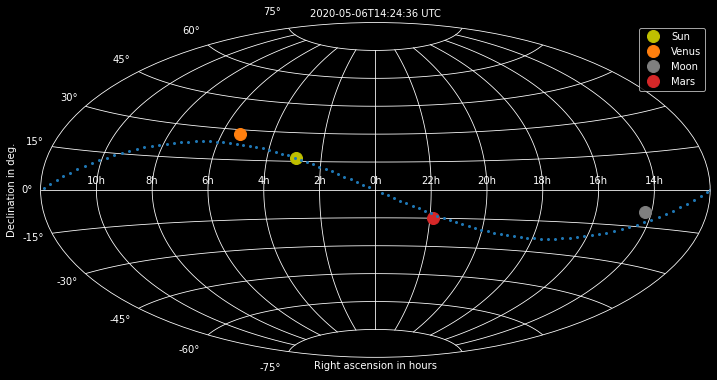

In [10]:
# We plot now the data in equatorial J2000. Again with a dark background and
# the same properties as before
plt.style.use('dark_background')
plt.figure(figsize=(12, 8))
plt.subplot(projection="aitoff")
plt.title(f'{DATETIME_UTC} UTC', fontsize=10)

# Iterate through the celestial bodies and plot them
for body_name, body_color in zip(SOLSYS_DICT, BODY_COLOR_ARRAY):

    plt.plot(solsys_df[f'{body_name}_long_rad4plot_equ'], \
             solsys_df[f'{body_name}_lat_rad_equ'], \
             color=body_color, marker='o', linestyle='None', markersize=12, \
             label=body_name.capitalize())

# Plot the Ecliptic plane as a blue dotted line
plt.plot(eclip_plane_df['j2000_long_rad4plot'], \
         eclip_plane_df['j2000_lat_rad'], color='tab:blue', linestyle='None', \
         marker='o', markersize=2)

# Convert the longitude values finally in right ascension hours
plt.xticks(ticks=np.radians([-150, -120, -90, -60, -30, 0, \
                             30, 60, 90, 120, 150]),
           labels=['10h', '8h', '6h', '4h', '2h', '0h', \
                   '22h', '20h', '18h', '16h', '14h'])

# Plot the labels
plt.xlabel('Right ascension in hours')
plt.ylabel('Declination in deg.')

# Create a legend and grid
plt.legend()
plt.grid(True)

# Save the figure
plt.savefig('j2000_sky_map.png', dpi=300)